# Initial Model #1
- Table of content
- Reading in data
- Performing EDA
- Dealing with missing
- Dealing with outliers 
- Transforming variables
- Feature Select
- Perform Train_test_split on train data to model
- Stacking models and performing CV

### Above the Dataset
- This dataset is from kaggle.com: Competition House Prices: Advanced Regression Techniques 
- We are given a dataset that consist of 79 features that will help us predict the house prices of Ames, Iowa! Fun!
- The dataset consists of 81 attributes and 1460 observation

In [5]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Read in data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#Save Id of each column to a different df
train_id = df_train['Id']
test_id = df_test['Id']
#Check the shape of training
df_train.shape

(1460, 81)

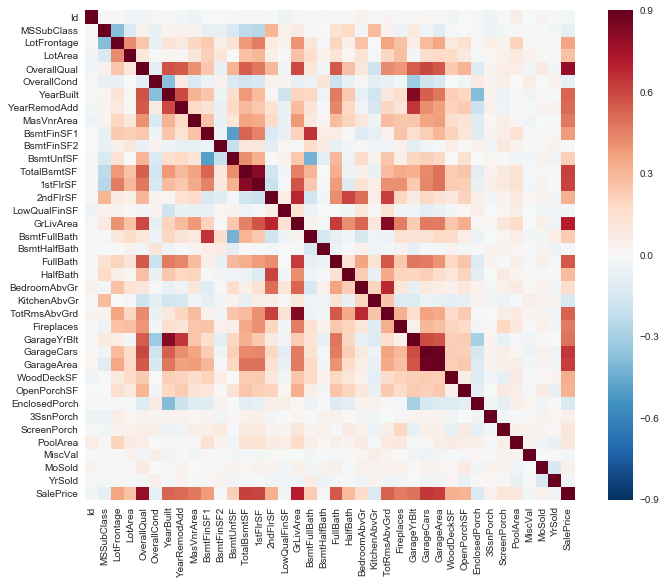

In [7]:
#Do a correlation analysis on the data to look at correlations
traincor = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(traincor, vmax=0.9, square=True)
plt.show()

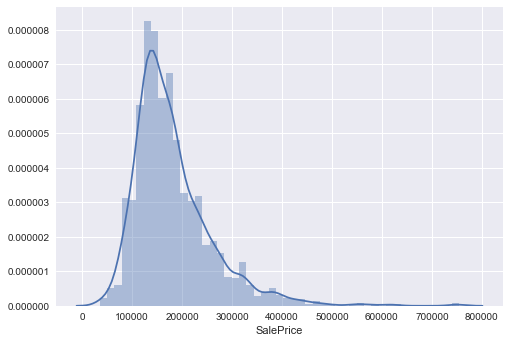

In [8]:
#Perform some EDA to look at the data
#Plot sales price by the count of sale price
g = sns.distplot(df_train['SalePrice'])
plt.show()

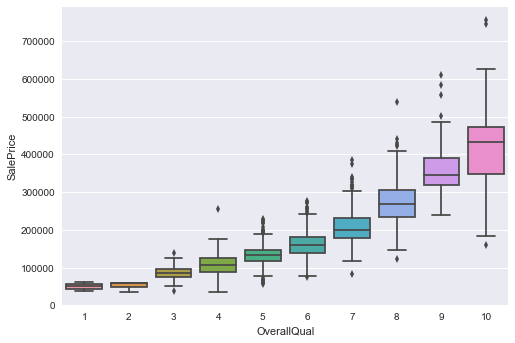

In [9]:
#Boxplot for overallqual
over_box = sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)
plt.show()

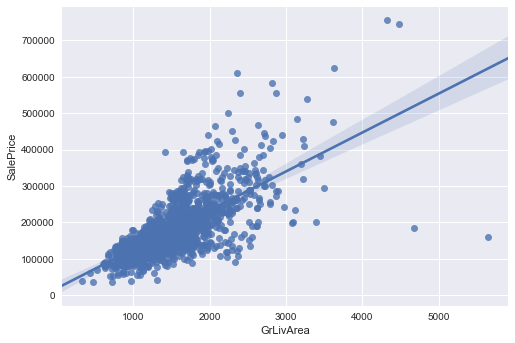

In [10]:
#Ground living area, as we see the higher the living area, the higher the saleprice
GrLivArea_box = sns.regplot(x='GrLivArea', y='SalePrice', data=df_train)
plt.show()

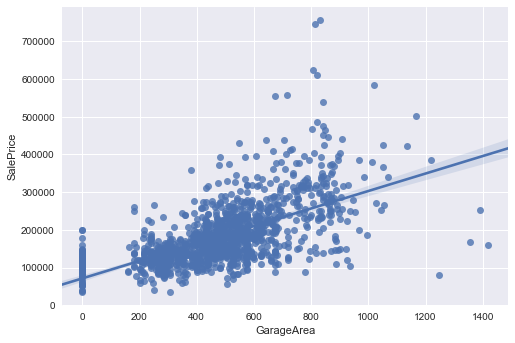

In [11]:
#Another great variable on contributing to buyers choice
GarageArea_box = sns.regplot(x='GarageArea', y='SalePrice', data=df_train)
plt.show()

## Looking at Missing Data

In [12]:
#Looking of Missing Value in train
df_train_NA = df_train.isnull()
df_train_nan = df_train_NA[df_train_NA == 1].count()
#Drop all columns that have no missing value 
df_NaN = df_train_nan[df_train_nan > 0]
df_NaN

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## Dealing with missing data

In [13]:
#Dropping all variables that have more than 50% missing
df_train = df_train.drop('PoolQC', axis=1)
df_train = df_train.drop(['MiscFeature','Alley','Fence'], axis=1)

In [14]:
# Dropping variables that is not relevent to buying or is already represented by another variable
#Drop all variables that doesn't means anything for home buying
#Dropp 1st and 2ndflr sf, which both equals to grlivarea

df_train = df_train.drop(['1stFlrSF','2ndFlrSF'], axis =1)

# Drop all garage and keep only garageQual and garageArea
df_train = df_train.drop(['GarageYrBlt','GarageType','GarageFinish', 'GarageCond', 'GarageCars'],axis=1)
df_train['GarageQual'] = df_train['GarageQual'].fillna('None')

# Impute the LotFrontage with median by nieghborhood
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#Fill fireplace with None for nan values
df_train['FireplaceQu'] = df_train["FireplaceQu"].fillna("None")

#Dropping all basement except from bsmtQual and fill it with None 
df_train = df_train.drop(['BsmtFinType1','BsmtFinType2','BsmtExposure', 'BsmtCond'],axis=1)
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('None')

#Dealing with MasVnrType and Area drop it for now, doesn't seem too interesting of a variable as prediction
df_train = df_train.drop(['MasVnrType','MasVnrArea'],axis=1)

#Electrical 
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

In [15]:
# Looking at the missing data again to check non are left
#Looking of Missing Value in train
df_train_NA = df_train.isnull()
df_train_nan = df_train_NA[df_train_NA == 1].count()
#Drop all columns that have no missing value 
df_NaN = df_train_nan[df_train_nan > 0]
df_NaN

Series([], dtype: int64)

## Dealing with outliers 

In [16]:
# Deleting two points that are clearing outliers from grlivarea and garageare
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [17]:
#Dropping the data points where garage area is greater than 1300
df_train = df_train.drop(df_train[df_train['GarageArea'] > 1300].index)

## Transforming variables

In [18]:
# #Transforming numerical variables
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

In [19]:
# Create Dummies for the rest of the categorical variables
df_train = pd.get_dummies(df_train)
df_train.shape

(1456, 236)

# Modeling

In [32]:
# Creating X and Y 
y = df_train['SalePrice']
x = df_train.loc[:, df_train.columns != 'SalePrice']

In [134]:
# Import modules for modeliing
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel, f_regression, RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

## Feature Selection

In [252]:
# Using RFE perform feature selection on the dataset
# feature extraction
model = Lasso(alpha =4 ,random_state=4)
rfe = RFE(model, 15)
fit = rfe.fit(x, y)
print(fit.n_features_)
fit1 = fit.support_
print(fit.ranking_)

15
[185 170 121 183  25  73 115 129 150 154 161 171 132   1  20 164  19  85
  71   1  82  43 138 167 169 173 163 162 126 184 107 105   1  35  88 189
 165  42 213 133  27  22  97  33  68 149 142  28 186 130  17  84  34 221
 220  31  57 112 207 209 102 143 108  18  38  55  37 144  40  50  63  48
   1  12  41 179  86 136 139   1 168  13  96 219  30 134 120  49  54 109
  61 200 180 160  47  11  81 205   5  95 210 113  23  24 106   7   8 172
  78 190   6 192 196  87 215 127  39  10 181   1 176 195 117 198   1  72
   4 197  26 119   1 204  15  90  98 152  89  74 101 208 104 201 193 156
  70   1 177  16  91 199  94  36 114  64 125 217   1  32 118  83  14 188
 146 182 153  21 110 116  51  79  66   1 211 131  77  75 206  76 191  80
   1 135  93 178 122  99 214 100 218 159 203  69 111 128   1 147 124 155
  65 194 137 103 166   1   2 202  45  46  92 148  44   9 158 157  56 151
 140 216  60 174  53 175   1 212 145  59   3  67  58  62 187 141  29 123
  52]


In [253]:
feature_list = dict(zip(x.columns, fit1))

In [254]:
#Def function to iterate each key and print out matching input value
def find_key(input_dict, value):
    return {k for k, v in input_dict.items() if v == value}

In [255]:
#Looking into feature_list and select all thats true, Top 10 Feature selected
top_features = find_key(feature_list, True)
features = list(top_features)

In [256]:
#Recreate new feature list call x_new and use that to predict all models 
x_new = df_train[features]
#Check shape to ensure it is only using the new x
x_new.shape

(1456, 15)

## Creating Baseline Models

In [257]:
#Train_test_split our data
# X_train, X_test, y_train, y_test = train_test_split(x_new,y, test_size= 0.3, random_state =10)

In [267]:
#Ridge regression
ridge = Ridge(normalize=True)
ridge.fit(x_new,y)
y_ridge_pred = ridge.predict(x_new)
ridge.score(x_new,y)

0.65691699122225933

In [259]:
# Lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =.4 ,random_state=4))
lass = lasso.fit(x_new,y)
y_las_pred = lasso.predict(x_new)
lasso.score(x_new, y)

0.75907406332501681

In [260]:
# ENEt
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
ENet.fit(x_new, y)
y_ENet_pred = ENet.predict(x_new)
ENet.score(x_new, y)

0.70683808352848554

In [261]:
#GBoost Model
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
GBoost.fit(x_new, y)
y_GB_pred = GBoost.predict(x_new)
GBoost.score(x_new,y)

0.81658898597274154

In [262]:
#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213, silent=1, random_state =7, nthread = -1)
model_xgb.fit(x_new, y)
y_xgb_pred = model_xgb.predict(x_new)
model_xgb.score(x_new, y)

0.87404217461997791

## Stacking Models

In [263]:
#Stacking the models together by using the y_pred of each model as new x and predict on y
# x_model = [y_ridge_pred,y_las_pred, y_ENet_pred, y_GB_pred,y_xgb_pred], axis=0)
ridge_pred = pd.DataFrame(y_ridge_pred)
las_pred = pd.DataFrame(y_las_pred)
ENet_pred = pd.DataFrame(y_ENet_pred)
GB_pred = pd.DataFrame(y_GB_pred)
xgb_pred = pd.DataFrame(y_xgb_pred)
x_model = pd.concat([ridge_pred,las_pred, ENet_pred, GB_pred,xgb_pred] ,axis=1)
#Renaming columns
x_model.columns = ['ridge_pred','las_pred','ENet_pred','GB_pred','xgb_pred']

In [264]:
#Train_test_split with new x model_x
#Train_test_split new x
X_train, X_test, y_train, y_test = train_test_split(x_model,y, test_size= 0.3, random_state =11)

In [265]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=2200,reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213, silent=1, random_state =7, nthread = -1)
model_xgb.fit(X_train, y_train)
y_xgb_pred = model_xgb.predict(X_test)
model_xgb.score(X_test, y_test)

0.82440266714886656

In [266]:
#Perform CV on model to see if the prediction is close
cv_results = cross_val_score(model_xgb,x_model,y,cv=5)
print(cv_results)
np.mean(cv_results)

[ 0.75934571  0.80995238  0.83176917  0.78544898  0.82818109]


0.80293946438637376

## Prediction score
- on XGBoost model, the model prediction score is 0.82 R^2 
    - With CV the score is about .80 R^2
- This is with 15 predictors, Next we will see if another preprocessing with work better
- If the model selects the best 25 predictors the R^2 increases to .87 